In [2]:
import os
import sys
import copy
import time
import random
import pyspark
from statistics import mean
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from sklearn.datasets import *
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer
from pyspark import SparkContext
#for cross validation
from sklearn.model_selection import cross_validate
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.regression import RandomForestRegressor
from pyspark.sql import functions as F

In [3]:
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Python Spark SQL basic example") \
        .config("spark.some.config.option", "some-value") \
        .getOrCreate()
    return spark

In [4]:
spark = init_spark()
import csv
from csv import reader
from array import array
filename = "./transformed_data.csv/transformed_data.csv"
import pyspark.sql.types as tp
myschema = tp.StructType([
    tp.StructField(name = "code"  , dataType = tp.StringType(), nullable = True),
    tp.StructField(name = "country"  , dataType = tp.StringType(), nullable = True),
    tp.StructField(name = "date"  , dataType = tp.StringType(), nullable = True),
    tp.StructField(name = "HDI"  , dataType = tp.DoubleType(), nullable = True),
    tp.StructField(name = "TC"  , dataType = tp.DoubleType(), nullable = True),
    tp.StructField(name = "TD"  , dataType = tp.DoubleType(), nullable = True),
    tp.StructField(name = "STI"  , dataType = tp.DoubleType(), nullable = True),
    tp.StructField(name = "POP"  , dataType = tp.DoubleType(), nullable = True),
    tp.StructField(name = "label"  , dataType = tp.DoubleType(), nullable = True) #label is the gdp
])
dataDF = spark.read.csv(filename, header=True,schema=myschema )

# create object of StringIndexer class and specify input and output column
country_obj = StringIndexer(inputCol='country',outputCol='country_index')

# transform the data
dataDF = country_obj.fit(dataDF).transform(dataDF)
dataDF = dataDF.drop("country","code","date")

# view the transformed data
dataDF.show(500)


+-----+-----------+-----------+-----------+-----------+-----------+-------------+
|  HDI|         TC|         TD|        STI|        POP|      label|country_index|
+-----+-----------+-----------+-----------+-----------+-----------+-------------+
|0.498|        0.0|        0.0|        0.0| 17.4772331|7.497754494|          0.0|
|0.498|        0.0|        0.0|        0.0| 17.4772331|7.497754494|          0.0|
|0.498|        0.0|        0.0|        0.0| 17.4772331|7.497754494|          0.0|
|0.498|        0.0|        0.0|        0.0| 17.4772331|7.497754494|          0.0|
|0.498|        0.0|        0.0|        0.0| 17.4772331|7.497754494|          0.0|
|0.498|        0.0|        0.0|        0.0| 17.4772331|7.497754494|          0.0|
|0.498|        0.0|        0.0|        0.0| 17.4772331|7.497754494|          0.0|
|0.498|        0.0|        0.0|        0.0| 17.4772331|7.497754494|          0.0|
|0.498|        0.0|        0.0|        0.0| 17.4772331|7.497754494|          0.0|
|0.498|        0

In [5]:


df = dataDF
from pyspark.ml.feature import VectorAssembler
feature_list = []
for col in df.columns:
    if col == 'label':
        continue
    else:
        feature_list.append(col)
assembler = VectorAssembler(inputCols=feature_list, outputCol="features").setHandleInvalid("skip")

rf = RandomForestRegressor(labelCol="label", featuresCol="features", maxBins= 210)
        
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[assembler, rf])

from pyspark.ml.tuning import ParamGridBuilder
import numpy as np
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [int(x) for x in np.linspace(start = 10, stop = 50, num = 3)]) \
    .addGrid(rf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 25, num = 3)]) \
    .build()

from pyspark.ml.tuning import CrossValidator
##crossvalidation for hyperparemeter tuning
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(),
                          numFolds=3)


(trainingData, testData) = df.randomSplit([0.8, 0.2])

#cvModel = pipeline.fit(trainingData)
cvModel = crossval.fit(trainingData)
predictions = cvModel.transform(testData)

In [6]:
evaluator = RegressionEvaluator(metricName="rmse", labelCol="label",predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.01832940891183926


In [7]:
#mae Mean Absolute Error 
evaluator = RegressionEvaluator(metricName="mae", labelCol="label",predictionCol="prediction")
mae = evaluator.evaluate(predictions)
print("Mean Absolute Error  = " + str(mae))

Mean Absolute Error  = 0.002026073147731225


In [8]:
predictions.select("prediction", "label", "features").show(5)

+-----------------+-----------+--------------------+
|       prediction|      label|            features|
+-----------------+-----------+--------------------+
|9.189712471999998|9.189712472|[0.0,2.995732274,...|
|9.189712471999998|9.189712472|[0.0,3.433987204,...|
|9.189712471999998|9.189712472|[0.0,4.521788577,...|
|9.189712471999998|9.189712472|[0.0,4.700480366,...|
|9.189712471999998|9.189712472|[0.0,4.86753445,0...|
+-----------------+-----------+--------------------+
only showing top 5 rows



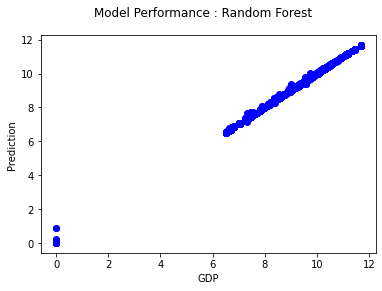

In [11]:
#for plotting graph
import matplotlib.pyplot as plt
rfPred = cvModel.transform(df)
rfResult = rfPred.toPandas()
plt.plot(rfResult.label, rfResult.prediction, 'bo')
plt.xlabel('GDP')
plt.ylabel('Prediction')
plt.suptitle("Model Performance : Random Forest")
#plt.suptitle("Model Performance MAE: %f" % mae)
plt.show()